# Sarcasm Detector

## Get and Load Data

In [2]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 270MB/s]


In [4]:
!pip install contractions
!pip install textsearch
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 7.0 MB/s 
     |████████████████████████████████| 106 kB 60.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
import contractions
import re
import tqdm

In [6]:

df = pd.read_json('./SarcasmDetect.json', lines=True)
df['headline'].iloc[1]

'dem rep. totally nails why congress is falling short on gender, racial equality'

In [7]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


## Remove all records with no headline text

In [9]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


###Splitting 40-30-30

In [10]:


X_train_val, X_test, y_train_val, y_test = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.3, random_state=42, stratify=df['is_sarcastic'])
X_train_val.shape, X_test.shape

((20033,), (8586,))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)
X_train.shape, X_val.shape

((14023,), (6010,))

In [12]:
type(X_train)

pandas.core.series.Series

### Functions for text normalisation

In [13]:
def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train = normalize_corpus(X_train)
X_val = normalize_corpus(X_val)
X_test = normalize_corpus(X_test)


100%|██████████| 8586/8586 [00:00<00:00, 56937.96it/s]


### Tokenization

In [14]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [15]:
train_sequences = t.texts_to_sequences(X_train)
val_sequences = t.texts_to_sequences(X_val)
test_sequences = t.texts_to_sequences(X_test)

In [16]:
max = 0
for doc in X_train:
  if max < len(doc):
    max = len(doc)  
print(max)

231


(0.0, 25.0)

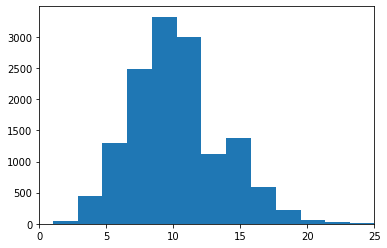

In [17]:
plt.hist([len(doc.split()) for doc in X_train], bins=20);

plt.xlim([0, 25])

In [18]:
MAX_SEQUENCE_LENGTH = 25

In [19]:
from matplotlib import test
# pad dataset to a maximum review length in words
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_pad.shape, X_test_pad.shape, X_val_pad.shape

((14023, 25), (8586, 25), (6010, 25))

### Fasttext

In [20]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

--2022-06-24 13:19:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  49.7MB/s    in 2m 20s  

2022-06-24 13:21:37 (39.7 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]



In [21]:
!unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


### Pretrained embeddings

In [22]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128
VOCAB_SIZE

18769

In [23]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [24]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(18769, 300)

### Gated recurrent units

In [25]:
# create the model
GRU_DIM = 128
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))


model.add(tf.keras.layers.GRU(GRU_DIM, return_sequences=True))
model.add(tf.keras.layers.GRU(GRU_DIM, return_sequences=False))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           5630700   
                                                                 
 gru (GRU)                   (None, 25, 128)           165120    
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               6

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train_pad, y_train, 
          validation_data=(X_val_pad, y_val),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
110/110 [==============================] - 11s 18ms/step - loss: 0.4381 - accuracy: 0.7868 - val_loss: 0.3487 - val_accuracy: 0.8391
Epoch 2/100
110/110 [==============================] - 1s 10ms/step - loss: 0.1721 - accuracy: 0.9363 - val_loss: 0.3676 - val_accuracy: 0.8516
Epoch 3/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0627 - accuracy: 0.9799 - val_loss: 0.5668 - val_accuracy: 0.8413
Epoch 3: early stopping


### Evaluation

In [27]:
predictions = model.predict(X_test_pad, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 84.35%
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4496
           1       0.90      0.75      0.82      4090

    accuracy                           0.84      8586
   macro avg       0.85      0.84      0.84      8586
weighted avg       0.85      0.84      0.84      8586



,0,1
0,4155,341
1,1003,3087


# Google's Universal Sentence Encoder

### Download USE

In [28]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

### USE embedding layer

In [29]:
model = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[], 
                           dtype=tf.string, trainable=True)


### Building the model

In [30]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.1, nesterov=False, name="SGD")

In [31]:
model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 512)              

### Fitting

In [32]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
    
model.fit(np.array(X_train), y_train, 
          validation_data=(np.array(X_val), y_val),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
110/110 [==============================] - 10s 45ms/step - loss: 0.6921 - accuracy: 0.5234 - val_loss: 0.6917 - val_accuracy: 0.5236
Epoch 2/100
110/110 [==============================] - 4s 39ms/step - loss: 0.6917 - accuracy: 0.5236 - val_loss: 0.6912 - val_accuracy: 0.5236
Epoch 3/100
110/110 [==============================] - 4s 35ms/step - loss: 0.6914 - accuracy: 0.5236 - val_loss: 0.6907 - val_accuracy: 0.5236
Epoch 4/100
110/110 [==============================] - 4s 39ms/step - loss: 0.6908 - accuracy: 0.5236 - val_loss: 0.6903 - val_accuracy: 0.5236
Epoch 5/100
110/110 [==============================] - 4s 37ms/step - loss: 0.6905 - accuracy: 0.5236 - val_loss: 0.6898 - val_accuracy: 0.5236
Epoch 6/100
110/110 [==============================] - 4s 39ms/step - loss: 0.6901 - accuracy: 0.5236 - val_loss: 0.6893 - val_accuracy: 0.5236
Epoch 7/100
110/110 [==============================] - 4s 34ms/step - loss: 0.6897 - accuracy: 0.5236 - val_loss: 0.6887 - val_accuracy

## Model Performance Evaluation on the Test Dataset

In [33]:
predictions = model.predict(np.array(X_test), batch_size=512, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 79.11%
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      4496
           1       0.77      0.80      0.79      4090

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



,0,1
0,3513,983
1,811,3279


# Bert

In [34]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.1 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 66.2 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [35]:
import transformers

In [36]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Input features

In [37]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [38]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               np.array(X_train), 
                                                                                               max_seq_length=MAX_SEQUENCE_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         np.array(X_val), 
                                                                                         max_seq_length=MAX_SEQUENCE_LENGTH)

Converting docs to features: 100%|██████████| 6010/6010 [00:04<00:00, 1283.55it/s]


### Model

In [50]:

inp_id = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1] 


dense1 = tf.keras.layers.Dense(128, activation='relu')(pooled_output) 
drop1 = tf.keras.layers.Dropout(0.15)(dense1)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output) 
drop1 = tf.keras.layers.Dropout(0.15)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.15)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

# model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
#                                            epsilon=1e-08), 
#               loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer=sgd, 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 25)]         0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 25)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]', 

### Fitting

In [51]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=7,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], y_train, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], y_val),
          epochs=15, 
          batch_size=64, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/15
220/220 [==============================] - 72s 262ms/step - loss: 0.4755 - accuracy: 0.7743 - val_loss: 0.4560 - val_accuracy: 0.7789
Epoch 2/15
220/220 [==============================] - 54s 245ms/step - loss: 0.3297 - accuracy: 0.8598 - val_loss: 0.2652 - val_accuracy: 0.8829
Epoch 3/15
220/220 [==============================] - 53s 243ms/step - loss: 0.2717 - accuracy: 0.8868 - val_loss: 0.4685 - val_accuracy: 0.8218
Epoch 4/15
220/220 [==============================] - 53s 243ms/step - loss: 0.2214 - accuracy: 0.9111 - val_loss: 1.9333 - val_accuracy: 0.5295
Epoch 5/15
220/220 [==============================] - 54s 245ms/step - loss: 0.1954 - accuracy: 0.9258 - val_loss: 0.2521 - val_accuracy: 0.8985
Epoch 6/15
220/220 [==============================] - 53s 242ms/step - loss: 0.1554 - accuracy: 0.9369 - val_loss: 0.3142 - val_accuracy: 0.8864
Epoch 7/15
220/220 [==============================] - 53s 243ms/step - loss: 0.1274 - accuracy: 0.9522 - val_loss: 0.4856 - val_ac

In [52]:
model.save_weights('bert_ft_wts.h5')

### Predictions and evaluation

In [53]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            X_test, 
                                                                                            max_seq_length=MAX_SEQUENCE_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:02<00:00, 2965.31it/s]


Test Features: (8586, 25) (8586, 25) (8586, 25)


In [54]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 89.66%
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4496
           1       0.90      0.88      0.89      4090

    accuracy                           0.90      8586
   macro avg       0.90      0.90      0.90      8586
weighted avg       0.90      0.90      0.90      8586



,0,1
0,4085,411
1,477,3613


In [44]:
f1, f2, f3 = create_bert_input_features(tokenizer, ['New Footage Shows Uvalde Police Rushing Into School To Take Selfies With Shooter'], max_seq_length=MAX_SEQUENCE_LENGTH)
print(model.predict([f1, f2, f3], verbose=0).ravel())

Converting docs to features: 100%|██████████| 1/1 [00:00<00:00, 1679.06it/s]

[0.6552598]
